In [1]:
import networkx as nx
import ModelConfig as mc
import IndependentCascadesModelP001 as icm
# import IndependentCascadesModelP010 as icm
# import WeightedCascadeModel as icm
import operator
import random 
import matplotlib.pyplot as plt
import numpy as np
import math
from concurrent.futures import ThreadPoolExecutor
import time

In [2]:
def InitViz():
    viz = []
    temp = []
    for i in range(len(list(g.nodes))): 
        temp.append(0)
    viz.append(temp)
    return viz

def InitModel(g):
    model = icm.IndependentCascadesModel(g)
    config = mc.Configuration()
    return model, config

def InfluenceSpread(model, config, target_set):
    config.add_model_initial_configuration("Infected", target_set)
    model.set_initial_status(config)
    active_set_size, newly_activated_nodes, step_activated_nodes = model.iteration_bunch()
    print('Step activated nodes:',step_activated_nodes)
    print('Active set size:', active_set_size)
    print('Newly activated nodes:', newly_activated_nodes)
    
    return active_set_size, newly_activated_nodes, step_activated_nodes

def Get_ActiveSetSize(g, target_set_size, strategy, sorted_graph):   
    '''
    Assuming continuous process (previously activated nodes cannot reattempt)
    As compared to one-time influence spread, all influencer same start point
    Default strategy set as greedy 
    '''
    model, config = InitModel(g)
    viz = InitViz()
    target_set = sorted_graph[0:target_set_size]
    
    viz_nest = viz[len(viz) - 1][:]
    for influencer in target_set:
        viz_nest[influencer] = 2
    viz.append(viz_nest)
    
    active_set_size, newly_activated_nodes, step_activated_nodes = InfluenceSpread(model, config, target_set)
    for nested_list in step_activated_nodes: 
        viz_nest = viz[len(viz) - 1][:]
        for node in nested_list: 
            viz_nest[node] = 1
        viz.append(viz_nest)
    return viz, active_set_size

In [3]:
def HighDegreeSort(g):
    sorted_hd = []
    for tup in sorted(g.degree, key=lambda x: x[1], reverse=True):
        sorted_hd.append(tup[0])
    return sorted_hd

In [4]:
def CentralitySort(g):
    '''
    Returns dictionary storing the average shortest distance of each node 
    '''
    print("CentralitySort: Running...")
    asd_dict = {} 
    for node in g.nodes():
        count_dist = 0
        node_paths = nx.shortest_path(g)[node]
        for value in node_paths.values():
            count_dist += len(value) - 1 # excluding start node
        asd_dict[node] = count_dist/len(g)
        print(f"{node}/{len(g)-1}")
    
    sorted_c = dict(sorted(asd_dict.items(), key=lambda item: item[1]))
    print("CentralitySort: Completed")
    print(list(sorted_c))
    return list(sorted_c)

def remove_isolated_nodes(g):
    isolated_nodes = []
    for pair in g.degree:
        node = pair[0]
        degree = pair[1]
        if degree == 0:
            isolated_nodes.append(node)

    for node in isolated_nodes:
        g.remove_node(node)
        
    return g

In [5]:
def GreedySort(g, tss_range, num_iterations=100):
    ''' 
    Select node with max average marginal gain
    Variable 'mg' refers to 'marginal gain'
    Number of iterations to find average marginal gain defaulted to 100
    '''
    model, config = InitModel(g)
    print("GreedySort: Running...")
    mg_dict = {}
    influence_dict = {}
    for candidate in g.nodes():
        mg = 0
        influence_list = []
        for i in range(num_iterations):
            newly_activated_nodes = GreedySim(model, config, candidate)
            mg += len(newly_activated_nodes)
            influence_list.append(len(newly_activated_nodes))
        avg_mg = mg/num_iterations
        mg_dict[candidate] = avg_mg
        influence_dict[candidate] = max(influence_list)
        print(f"{candidate}/{len(g)-1}")
        
    print("GreedySort: Completed")
    mg_list = list(sorted(mg_dict.items(), key=lambda item: item[1], reverse=True))
    influence_list = list(sorted(mg_dict.items(), key=lambda item: item[1], reverse=True))
    rg_list = sorted(random.choices(mg_list, k=tss_range), key=lambda item: item[1], reverse=True)
    r_list = sorted(random.choices(influence_list, k=tss_range), key=lambda item: item[1], reverse=True)

    sorted_g = []
    sorted_rg = []
    sorted_r = []
    for tup in mg_list:
        sorted_g.append(tup[0])
    for tup in rg_list:
        sorted_rg.append(tup[0])
    for tup in r_list:
        sorted_r.append(tup[0])

    return sorted_g, sorted_rg, sorted_r

def GreedySim(model, config, candidate):
    config.add_model_initial_configuration("Infected", [candidate])
    model.set_initial_status(config)
    active_set_size, newly_activated_nodes, step_activated_nodes = model.iteration_bunch()
    newly_activated_nodes.append(candidate)
    model.mg_reset(newly_activated_nodes)
    return newly_activated_nodes

In [6]:
g = nx.gnm_random_graph(50, 150)
g = remove_isolated_nodes(g)

sorted_c = CentralitySort(g)

target_set_size = 5

strategy = 'centrality'
viz_centrality, active_set_size = Get_ActiveSetSize(g, target_set_size, strategy, sorted_c)
print('Active Set Size: ')
print(active_set_size)
print()
print('Viz Centrality')
print(viz_centrality)




CentralitySort: Running...
0/49
1/49
2/49
3/49
4/49
5/49
6/49
7/49
8/49
9/49
10/49
11/49
12/49
13/49
14/49
15/49
16/49
17/49
18/49
19/49
20/49
21/49
22/49
23/49
24/49
25/49
26/49
27/49
28/49
29/49
30/49
31/49
32/49
33/49
34/49
35/49
36/49
37/49
38/49
39/49
40/49
41/49
42/49
43/49
44/49
45/49
46/49
47/49
48/49
49/49
CentralitySort: Completed
[3, 8, 11, 48, 21, 7, 15, 23, 45, 1, 16, 20, 31, 34, 38, 44, 27, 29, 33, 42, 19, 22, 39, 25, 32, 5, 12, 13, 17, 18, 28, 36, 46, 6, 43, 49, 30, 37, 9, 14, 10, 0, 2, 41, 40, 26, 35, 24, 47, 4]
Step activated nodes: [[33], [], []]
Active set size: 6
Newly activated nodes: [33]
Active Set Size: 
6

Viz Centrality
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0

D:\anaconda35\lib\site-packages\ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "D:\anaconda35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\anaconda35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\anaconda35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\anaconda35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\anaconda35\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "D:\anaconda35\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
 

TypeError: float() argument must be a string or a number, not 'dict_values'

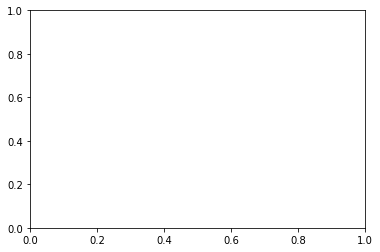

In [7]:
import numpy as np
import matplotlib.pyplot as plt; plt.close('all')
import networkx as nx
import matplotlib
from matplotlib import animation

matplotlib.use('TkAgg')

pos = nx.spring_layout(g)

# draw graph
# nodes = nx.draw_networkx_nodes(g, pos, *args, **kwargs)
# edges = nx.draw_networkx_edges(g, pos, *args, **kwargs)

statuses = viz_centrality
colors = {0: 'gray', 1: 'blue', 2: 'red'}

def status():
    for s in statuses: 
        yield list(map(lambda x: colors[x], s))
color_map = status()


def draw_next_status(n):
    plt.cla()
    c_map = next(color_map, colors.values())
    nx.draw(g, pos, node_color=c_map, node_size=50)



ani = animation.FuncAnimation(plt.gcf(), draw_next_status, interval=1000, frames=len(statuses), repeat=False)
ani.save('icm_centrality.gif', writer = 'pillow ', savefig_kwargs={'facecolor':'white'}, fps=0.3)
